In [1]:
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from tqdm import tqdm
from sklearn.metrics.pairwise import  pairwise_distances

import skimage.io as io
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable

sys.path.append('../')
import metrics
%matplotlib inline

In [2]:
dataDir='../../coco_dataset/'
imagesDirTrain = '{}train2017'.format(dataDir)
imagesDirVal = '{}val2017'.format(dataDir)

annTrainFile = '{}annotations/captions_train2017.json'.format(dataDir)
annValFile = '{}annotations/captions_val2017.json'.format(dataDir)

In [3]:
def numpy2image(img_numpy):
    if img_numpy.dtype == np.dtype('float64'): #нужно домножить на 255 и поменять тип
        img_numpy = (img_numpy*255).astype('uint8')
    return Image.fromarray(img_numpy)


class MSCOCODataset(Dataset):
    """MSCOCO Dataset"""

    def __init__(self, annFile, imagesDir, transform=None):
        self.coco = COCO(annFile)
        self.imagesDir = imagesDir
        self.imageids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.coco.dataset['images'])

    def __getitem__(self, idx):
        imid = self.imageids[idx]
        img_data = self.coco.loadImgs([imid])[0]
        
        img_file_name = '{}/{}'.format(self.imagesDir, img_data['file_name'])
        image = io.imread(img_file_name)
        
        if len(image.shape) != 3:
            return self.__getitem__(0)
        
        image = numpy2image(image)
        if self.transform is not None:
            image = self.transform(image)
            
        sample = {'image': image, 'id': imid}
            
        return sample

In [4]:
class KNN:
    def __init__(self, k, coco, model, pretrained=False):
        '''
        k: int, count of nearest neighborhood
        coco: COCO(annTrainFile), annTrainFile - file with annotations of train dataset
        model: torchvision.models, pretrained classifier model
        pretrained: bool, if True load converted images for files
        '''
        self.k = k
        self.coco = coco
        self.cnn = model
        self.mertric = metrics.bleu
        self.pretrained = pretrained
       
    def images2vec(self, loader, max_batch_iter):
        '''
        Convert each image in vector(torch array)
        loader: Dataloader(MSCOCODataset)       
        return: (torch.array, torch.array)
        '''
        if len(loader) == 0:
            raise SyntaxError('\rError: empty input in method images2vec()')
        
        res = None
        res_ids = None
        for i, item in tqdm(enumerate(loader)):
            
            X = Variable(item['image'].type(torch.cuda.FloatTensor))
            ids = item['id']
            
            vec = self.cnn.forward(X).data.cpu()
            
            if res is None:
                res = vec
                res_ids = ids
            else:
                res = torch.cat((res, vec), 0)
                res_ids = torch.cat((res_ids, ids), 0)
                
            if i == max_batch_iter - 1:
                break
                
        return res, res_ids
            
    def predict(self, train_loader, test_loader, max_batch_iter=10):
        '''
        Create pretrained dataset for algorithm
        train_loader: Dataloader(MSCOCODataset)
        test_loader: Dataloader(MSCOCODataset)
        return: dict, key is <mscoco_id> of each image, value is annotation
        '''
        if len(train_loader) == 0 or len(test_loader) == 0:
            raise SyntaxError('\rError: empty input in method predict()')
        
        if self.pretrained:
            train_image = torch.load('train_image.pth')
            train_image_id = torch.load('train_image_id.pth')
            test_image = torch.load('test_image.pth')
            test_image_id = torch.load('test_image_id.pth')
        else:
            train_image, train_image_id = self.images2vec(train_loader, max_batch_iter)
            test_image, test_image_id = self.images2vec(test_loader, max_batch_iter)
            
            print "Congratulations! All images converted"
            
            torch.save(train_image, 'train_image.pth')
            torch.save(train_image_id, 'train_image_id.pth')
            torch.save(test_image, 'test_image.pth')
            torch.save(test_image_id, 'test_image_id.pth')
        
        pairs = pairwise_distances(test_image, train_image)                
        nearest_ids = np.zeros((test_image.size(0), self.k))
        
        for i in range(self.k):
            ids = np.argmin(pairs, 1)
            nearest_ids[:, i] = ids[:]
            for i, idx in enumerate(ids):
                pairs[i, idx] = 10**3
        nearest_ids = nearest_ids.astype(np.int)
        
        res = {}
        for it in tqdm(range(nearest_ids.shape[0])):
            anns_ids = self.coco.getAnnIds(imgIds=train_image_id[nearest_ids[it]])
            anns = self.coco.loadAnns(anns_ids)
            anns = [ann['caption'] for ann in anns]
            dist_sim = np.zeros((len(anns), len(anns)))
            
            for i in range(len(anns)):
                for j in range(i + 1, len(anns)):
                    
                    dist_sim[i][j] = self.mertric(anns[i], anns[j], n=4)
                    dist_sim[j][i] = self.mertric(anns[j], anns[i], n=4)
            
            dist_sim_sum = dist_sim.sum(0)
            res[test_image_id[it]] = anns[np.argmax(dist_sim_sum)]
            
        return res

In [5]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                             transforms.ToTensor(), 
                                             transforms.Normalize(
                                                 mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])

train_dataset = MSCOCODataset(annTrainFile, imagesDirTrain, transform)
test_dataset = MSCOCODataset(annValFile, imagesDirVal, transform)

train_dataloader = DataLoader(train_dataset, batch_size=258)
test_dataloader = DataLoader(test_dataset, batch_size=32)

torch.cuda.set_device(2)
model = models.alexnet(pretrained=True).cuda()

loading annotations into memory...
Done (t=4.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [6]:
m = KNN(20, COCO(annTrainFile), model, True)

loading annotations into memory...
Done (t=4.80s)
creating index...
index created!


In [ ]:
res = m.predict(train_dataloader, test_dataloader, 100)

  8%|▊         | 254/3200 [03:39<42:28,  1.16it/s] 

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Three zebras are grazing in a grassy field.


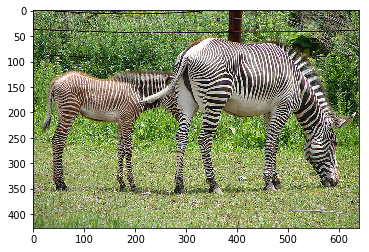

In [16]:
val_coco = COCO(annValFile)
for i, key in enumerate(res.keys()):
    if i != 15:
        continue
    img_data = val_coco.loadImgs([key])[0]
    img_file_name = '{}/{}'.format(imagesDirVal, img_data['file_name'])
    image = io.imread(img_file_name)
    plt.imshow(image)
    print res[key]
    break